In [110]:
! pip install nltk

In [5]:
import os
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation


In [13]:
import pandas as pd

In [6]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [24]:
!ls


topic_data.txt	topic_modeling.ipynb


In [7]:
docs, titles = load_data('/home/jovyan/git/topic_modeling'
, 'topic_data.txt')

Total Number of Documents: 4551


In [8]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        stemmed_tokens = ' '.join(stemmed_tokens)
        texts.append(stemmed_tokens)
        
    return texts

In [9]:
prep_docs = preprocess_data(docs)

In [10]:
len(prep_docs)

4551

In [16]:
def tfidf_vectorizer(prep_docs, n_features = 50, param_min_df = 2, param_max_df = 0.95):

    print("Extracting tf-idf features ...")
    tfidf = TfidfVectorizer(max_df = param_max_df, min_df = param_min_df,
                                       max_features=n_features,
                                       stop_words='english')
    # tfidf_vec_sparse = tfidf.fit_transform(docs)
    tfidf_vec_sparse = tfidf.fit_transform(prep_docs)
    feature_names = tfidf.get_feature_names()

    return tfidf_vec_sparse, feature_names

In [17]:
# tfidf_vec_sparse = tfidf.fit_transform(docs)
tfidf_vec_sparse, feature_names = tfidf_vectorizer(prep_docs, n_features = 50, param_min_df = 2, param_max_df = 0.95)

tfidf_vec_df = pd.DataFrame(tfidf_vec_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_vec_df.head()

Extracting tf-idf features ...


,ask,bank,brexit,campaign,chang,citi,clinton,come,countri,day,...,trump,uk,use,vote,want,way,week,work,world,year
0,0.290731,0.855437,0.0,0.000000,0.000000,0.109713,0.000000,0.076709,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.075749,0.000000,0.000000,0.000000,0.058920
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.737285,0.000000,0.000000,0.239646,...,0.487522,0.0,0.082145,0.108071,0.081123,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.259301,0.320335,0.000000,...,0.000000,0.0,0.279841,0.000000,0.000000,0.000000,0.000000,0.000000,0.292588,0.000000
3,0.046292,0.000000,0.0,0.290619,0.000000,0.052408,0.141971,0.036642,0.000000,0.038455,...,0.586729,0.0,0.000000,0.052025,0.000000,0.000000,0.041094,0.000000,0.000000,0.000000
4,0.046648,0.000000,0.0,0.244046,0.171658,0.000000,0.429190,0.000000,0.091230,0.155004,...,0.650369,0.0,0.079698,0.104851,0.078705,0.072924,0.000000,0.034682,0.124992,0.056722


In [ ]:
tfidf_vec_sparse.toarray().shape

In [50]:
n_topics = 10
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=n_topics, n_iter=100, random_state=42)
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lsa.fit(tfidf_vec_sparse)
lda.fit(tfidf_vec_sparse)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [ ]:
lsa

In [51]:
emd = lsa.transform(tfidf_vec_sparse.toarray())

In [52]:
emd.shape

(4551, 10)

In [20]:
sing_vals = lsa.singular_values_

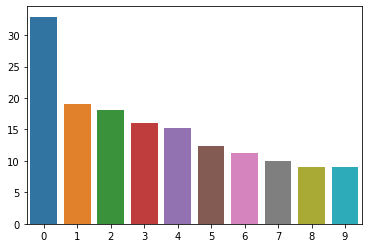

In [53]:
import seaborn as sns

sns.barplot(x=list(range(len(sing_vals))), y = sing_vals)


In [32]:
lsa.components_.shape

(10, 50)

In [28]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

Exploratory Data Analysis (EDA)

In [29]:
n_top_words = 10
print_top_words(lsa, feature_names, n_top_words)

Topic #0: said year like peopl say time film new trump work
Topic #1: trump clinton said campaign vote state eu parti polit brexit
Topic #2: bank eu uk brexit said govern vote leav report year
Topic #3: bank film trump said clinton report includ year state new
Topic #4: film eu brexit uk vote leav campaign govern parti said
Topic #5: said report year includ peopl use need support govern ask
Topic #6: play citi point said time eu end start look right
Topic #7: year uk new includ world live report week citi govern
Topic #8: citi say report govern peopl support point parti film need
Topic #9: uk say play use trump eu includ citi good world



In [54]:
n_top_words = 10
print_top_words(lda, feature_names, n_top_words)

Topic #0: bank said year govern uk report new time includ say
Topic #1: govern countri said peopl uk year need right support world
Topic #2: say peopl like thing work year time know want think
Topic #3: eu brexit vote uk said leav campaign govern peopl say
Topic #4: trump clinton said state campaign vote peopl polit parti support
Topic #5: play citi time point like said look year start good
Topic #6: live like year new make end world way time come
Topic #7: parti polit vote right brexit peopl chang work like new
Topic #8: film play year new like work time make said world
Topic #9: said year report use includ peopl new work uk time



In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [56]:
tsne = TSNE(n_components=2)
tsne_emb = tsne.fit_transform(emd)

In [65]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string

path='news_data'
if not os.path.exists(path):
    os.mkdir(path)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20_newsgroups.tar.gz"

response = requests.get(url)
name = os.path.basename(url)
with open(os.path.join(path, name), 'bw') as f:
    f.write(response.content)


In [137]:
def clean_text(text):
    # split into words
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # # filter out stop words
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    words = ' '.join(words)
    return words

In [77]:
TEXT_DIR = 'news_data/20_newsgroups'

In [158]:
news_topics = []
new_text = []
topic_label = []
c= 0
i = 0
for names in sorted(os.listdir(TEXT_DIR)):
    c+=1
    path = os.path.join(TEXT_DIR, names)
    if c < 10:
        if os.path.isdir(path):
            i+=1
            news_topics.append(names)
            for fname in sorted(os.listdir(path)):
                fpath = os.path.join(path, fname)
                with open(fpath, 'rb') as f:
                    t = f.read().decode('utf-8',errors='ignore')
                    t = clean_text(t)
                    new_text.append(t)
                    topic_label.append(i)
            
                    
                    
    

In [160]:
tfidf_vec_sparse, feature_names = tfidf_vectorizer(new_text, n_features = 100)

n_topics = 10
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=n_topics, n_iter=100, random_state=42)
# lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
#                                 learning_method='online',
#                                 learning_offset=50.,
#                                 random_state=0)

lsa.fit(tfidf_vec_sparse)
embding = lsa.transform(tfidf_vec_sparse)

# lda.fit(tfidf_vec_sparse)

Extracting tf-idf features ...


In [155]:
lsa.components_.shape

(10, 100)

In [163]:
tsne = TSNE(n_components=2)
tsne_emb = tsne.fit_transform(embding)

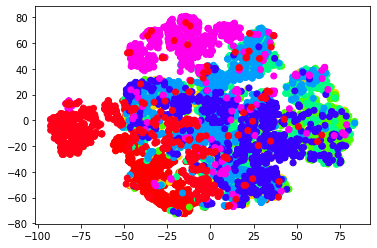

In [169]:
plt.scatter(tsne_emb[:,0], tsne_emb[:, 1], c = topic_label, cmap='hsv')

In [ ]:
from sklearn.manifold import MDS
mds = MDS(n_components=2)
mds_emb = mds.fit_transform(embding)

plt.scatter(mds_emb[:,0], mds_emb[:, 1], c = topic_label, cmap='hsv')